In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load the dataset
data = pd.read_csv('/Users/priyakundu/Downloads/updated_dataset.csv')

data

,Unnamed: 0,v,vw,o,c,h,l,n,date,daily_return,day_of_the_week,is_outlier,10-day MA,30-day Volatility,RSI,Price_Up_Down
0,0,69913,1.0329,1.03606,1.02891,1.041960,1.02621,69913,2010-01-04,0.004374,Monday,0,1.038591,0.082918,45.330339,1
1,1,76822,1.0304,1.02900,1.03341,1.035960,1.02515,76822,2010-01-05,0.004374,Tuesday,0,1.037668,0.082918,51.991311,0
2,2,81057,1.0321,1.03341,1.02746,1.037830,1.02480,81057,2010-01-06,-0.005758,Wednesday,0,1.035867,0.082918,38.022523,1
3,3,72488,1.0321,1.02744,1.03370,1.037050,1.02414,72488,2010-01-07,0.006073,Thursday,0,1.034403,0.082918,45.471928,0
4,4,73991,1.0311,1.03375,1.02325,1.038370,1.02151,73991,2010-01-08,-0.010109,Friday,0,1.032823,0.082918,30.990099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,3568,12916,0.8563,0.85534,0.85581,0.858300,0.85380,12916,2023-12-25,0.000129,Monday,0,0.863986,0.060472,23.933565,0
3569,3569,112192,0.8555,0.85600,0.85372,0.857960,0.85280,112192,2023-12-26,-0.002442,Tuesday,0,0.861848,0.048946,22.794404,0
3570,3570,174820,0.8495,0.85359,0.84250,0.854870,0.84060,174820,2023-12-27,-0.013142,Wednesday,0,0.859001,0.060001,16.314069,1
3571,3571,196178,0.8392,0.84240,0.84337,0.845145,0.83300,196178,2023-12-28,0.001033,Thursday,0,0.856630,0.059782,10.057586,0


In [3]:
# Convert 'date' to datetime and sort the data by date to ensure correct temporal splitting
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Create shifted targets for the next 5 days
for i in range(1, 6):
    data[f'Price_Up_Down_Day_{i}'] = data['Price_Up_Down'].shift(-i)

# Drop rows with NaN values created by shifting
data.dropna(inplace=True)

# Encode 'day_of_the_week' and normalize features
data = pd.get_dummies(data, columns=['day_of_the_week'])
scaler = MinMaxScaler()
numerical_features = ['vw','c', 'n', 'daily_return', '10-day MA', '30-day Volatility', 'RSI']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [4]:
# Prepare datasets for model input
features_to_keep = numerical_features + [col for col in data.columns if 'day_of_the_week' in col]
X = data[features_to_keep].values
y = data[[f'Price_Up_Down_Day_{i}' for i in range(1, 6)]].values

# Ensure all data are floats and check for NaNs
X = X.astype('float32')  # Convert X to float32 explicitly
y = y.astype('float32')  # Convert y to float32 explicitly

# Convert X to a 3D shape [samples, time steps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Time-based splitting
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check shapes to confirm setup
X_train.shape, y_train.shape

((2854, 1, 12), (2854, 5))

In [19]:
# Define the LSTM model
model = Sequential()
# First LSTM layer with more units
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.3))
# Adding a GRU layer
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.3))
# Second LSTM layer with more units
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
# Adding more densely connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))  # Output layer for 5 days predictions

# Compile with a smaller learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0679 - loss: 0.6931 - val_accuracy: 0.2059 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1489 - loss: 0.6929 - val_accuracy: 0.0518 - val_loss: 0.6931 - learning_rate: 5.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0726 - loss: 0.6928 - val_accuracy: 0.1331 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1798 - loss: 0.6925 - val_accuracy: 0.1331 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1193 - loss: 0.6926 - val_accuracy: 0.1611 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1041 - loss: 0.6922 - val_accuracy: 0.1218 - val_loss: 0.6934 - learning_rate: 5.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1371

In [20]:
# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2282 - loss: 0.6926 
Accuracy: 20.59


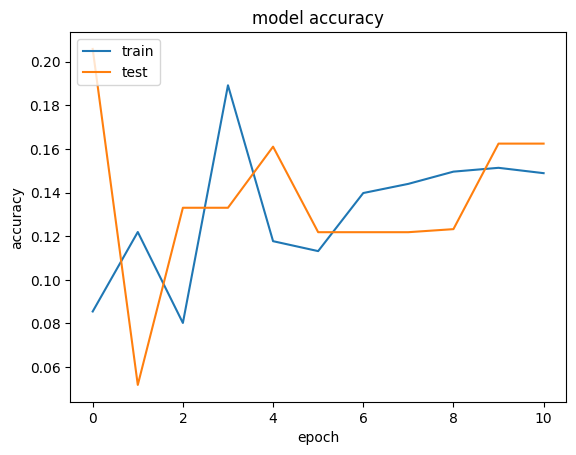

In [21]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()